In [1]:
import os
os.chdir('../')
current_path = os.getcwd() 

print(current_path)

/home/lcad/blastfurnace


In [21]:
from blastfurnace.config import get_cfg
from blastfurnace.utils.defaults import default_setup
from blastfurnace.data.datasets import ArcelorMittalDataset

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import glob
import pandas as pd
import numpy as np

In [50]:
cfg = get_cfg()
cfg.merge_from_file('configs/run_max_temp/LINEAR_NORMALIZATION.yaml')
cfg.freeze()

full_dataset = ArcelorMittalDataset(cfg["DATASET"])

x, y, full_x, full_y, feature_names = full_dataset.build_dataset()
splits = full_dataset.all_to_splits(x, y, full_y, full_dataset.all_x)
test_x, test_y, test_full_y, test_full_x = splits["test"]
train_x, train_y, train_full_y, train_full_x = splits["train"]

- Extrapolating features: 100%|█████████████████████████████████████████████████| 5793/5793 [00:01<00:00, 2999.03it/s]


In [51]:
train_full_x.loc[:, ('temperature')] = train_y
train_full_x.loc[:, ('run_id')] = train_full_y['run_id']
train_full_x.loc[:, ('date')] = train_full_y['date']
train_full_x


/tmp/ipykernel_40971/2751167967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_full_x.loc[:, ('temperature')] = train_y
/tmp/ipykernel_40971/2751167967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_full_x.loc[:, ('run_id')] = train_full_y['run_id']
/tmp/ipykernel_40971/2751167967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

,delta_time_previous30min,run_max_temp_t1,delta_time_max_run_t1,run_max_temp_tsame1,delta_time_max_tsame1,processo_volume-de-sopro,indices_operacionais_taxa-de-o2,processo_umidade-do-ar-de-sopro,processo_temperatura-do-ar-de-sopro,processo_vazao-de-carvao-na-linha-principal,...,lag_15_processo_temperatura-do-ar-de-sopro,lag_15_processo_vazao-de-carvao-na-linha-principal,lag_15_processo_pressao-do-topo,lag_15_carga_peso-total-seco-coque,lag_15_carga_peso-total-de-minerio,lag_15_carga_coque-rate,lag_15_carga_minerio-rate,temperature,run_id,date
0,-1.110906,0.592593,-0.822649,0.925926,1.402857,-0.321422,0.325029,0.015190,0.850186,0.437104,...,0.901206,0.314932,0.0,-0.934658,-0.740596,-4.923262,-5.097123,0.888889,14045.0,2017-01-02 02:00:00
1,-1.116571,0.592593,-0.717470,0.925926,1.508036,-0.342785,0.359212,0.000000,0.997217,0.424434,...,0.932282,0.202715,0.0,-0.115619,0.200371,-4.923262,-5.097123,0.888889,14045.0,2017-01-02 02:30:00
2,-1.180122,0.592593,-0.670177,0.925926,1.555330,-0.319819,0.300695,-0.030380,0.799165,0.477828,...,0.873377,0.290498,0.0,-0.247525,0.011962,-4.923262,-5.097123,0.888889,14045.0,2017-01-02 03:00:00
3,-1.132028,0.888889,-0.335365,0.888889,-0.335365,-0.193533,0.271147,-0.362025,0.925788,-0.038009,...,0.866419,0.284163,0.0,0.200206,0.565815,-4.923262,-5.097123,0.925926,14047.0,2017-01-02 06:00:00
4,-1.119712,0.888889,-0.212205,0.888889,-0.212205,-0.297679,0.300695,-0.374684,0.509740,0.261538,...,0.875232,0.167421,0.0,0.203108,0.559286,-4.923262,-5.097123,0.925926,14047.0,2017-01-02 06:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38504,-1.103024,2.333333,-0.445348,1.962963,0.184494,0.204506,0.528969,1.508861,-0.976345,-0.037104,...,-1.868738,-0.557466,0.0,0.447242,-0.005634,0.902204,0.651528,1.111111,23473.0,2019-12-31 21:30:00
38505,-1.144159,2.333333,-0.375639,1.962963,0.254203,0.232230,0.503476,0.668354,-0.854824,0.267873,...,-1.886827,-0.551131,0.0,1.573206,1.167929,0.909817,0.668387,1.111111,23473.0,2019-12-31 22:00:00
38506,-1.183016,2.333333,-0.303652,1.962963,0.326190,0.201690,0.523175,0.496203,-1.028293,0.352941,...,-2.010668,-0.447059,0.0,0.361274,-0.011927,0.766963,0.640903,1.111111,23473.0,2019-12-31 22:30:00
38507,-1.102469,2.333333,-0.223166,1.962963,0.406675,0.201690,0.523175,0.496203,-1.028293,0.352941,...,-2.010668,-0.447059,0.0,0.361274,-0.011927,0.766963,0.640903,1.111111,23473.0,2019-12-31 22:30:00


In [52]:
gb = train_full_x.loc[train_full_x.groupby(['run_id'])['temperature'].idxmax()]
gb['date_prev_run_max_temp'] = gb['date'].shift(periods=1,fill_value=0)

def calculate_deltas(vector):
    tam = len(vector)//2
    qtd1 = 0
    qtd2 = 0
    sum1 = 0
    sum2 = 0
    
    if tam == 0:
        return vector[0]
    else:
        for i in range(tam):
            sum1 += vector[i]
            qtd1 += 1
        for i in range(tam,len(vector)):
            sum2 += vector[i]
            qtd2 += 1
        return sum2/qtd2 - sum1/qtd1 

/tmp/ipykernel_40971/206895954.py:2: FutureWarning: Passing <class 'int'> to shift is deprecated and will raise in a future version, pass Timestamp instead.
  gb['date_prev_run_max_temp'] = gb['date'].shift(periods=1,fill_value=0)


In [53]:
j = 0
b = dict()
for index, row in gb.iterrows():
    if index == 0:
        b[0]=0
        j+=1
        continue
    max_lag = (row['date'] - row['date_prev_run_max_temp'])
    max_lag = max_lag/np.timedelta64(30,'m')
    max_lag = int(max_lag)
    print(max_lag)
    a = dict()
    a[0] = row["processo_vazao-de-carvao-na-linha-principal"]
    if max_lag>15:
        max_lag=15
    for i in range(1,max_lag+1):
        a[i]=row[f"lag_{i}_processo_vazao-de-carvao-na-linha-principal"]
    b[j] = calculate_deltas(a)
    j+=1
gb['id_delta_vazao_carvao'] = b
gb['delta_vazao_carvao'] = gb['id_delta_vazao_carvao'].map(b)

8
5
4
6
5
6
6
5
5
5
6
4
5
6
5
6
5
5
5
6
5
6
5
7
5
7
6
5
7
6
4
6
6
2
7
8
7
7
3
5
6
4
5
4
7
3
4
5
3
5
6
5
5
5
4
6
6
5
4
5
6
6
5
8
5
5
3
4
7
4
6
7
3
5
5
4
4
7
5
6
5
6
4
6
7
5
3
7
6
63
5
7
5
6
5
6
7
7
4
6
4
6
6
5
7
5
6
6
5
6
5
4
3
5
6
5
5
6
8
7
3
168
5
6
8
6
4
6
6
4
4
5
3
4
4
6
6
6
6
6
4
3
2
5
5
5
5
4
4
7
5
3
5
5
4
4
2
4
5
4
7
5
4
7
5
5
4
5
4
14
4
4
5
5
6
5
6
3
4
4
4
5
4
5
4
6
5
5
5
6
5
6
5
5
5
4
6
5
5
4
5
5
6
4
3
5
5
5
6
11
8
11
4
4
5
5
4
8
6
4
6
5
3
6
6
5
5
4
6
5
7
4
5
4
4
5
5
5
5
5
3
6
5
6
6
5
6
5
7
4
3
5
4
4
6
5
4
5
6
4
5
4
7
5
5
5
4
9
4
5
7
4
6
6
8
4
6
5
6
5
3
7
4
4
6
5
6
7
4
6
5
5
4
5
4
7
6
6
6
5
4
5
4
5
5
5
5
6
5
5
5
5
5
4
6
4
7
6
4
5
6
5
5
5
5
5
6
5
1
3
4
4
5
5
5
4
7
4
5
5
5
5
5
7
5
6
5
5
6
6
4
6
3
6
6
5
6
6
4
6
6
4
6
6
6
9
5
6
5
7
67
5
5
5
4
5
7
4
7
3
5
7
6
5
6
3
11
5
4
5
6
6
6
3
7
3
6
5
6
6
5
5
4
4
5
6
5
5
5
2
5
5
5
7
6
5
4
5
6
5
6
3
6
4
4
5
6
4
6
5
5
5
5
6
6
6
5
5
5
5
5
4
7
10
4
5
6
5
3
5
5
6
2
6
5
5
6
5
8
3
4
5
5
5
6
5
5
8
5
4
5
5
5
4
5
5
7
5
6
5
5
8
6
3
4
5
6
6
6
6
4
7
4
5
5
9

7
5
7
4
8
6
6
4
8
4
6
6
6
6
5
5
7
6
4
5
5
7
4
5
6
7
6
4
6
4
5
5
5
7
4
6
7
6
4
11
4
6
5
6
7
4
6
4
5
5
3
5
5
7
3
6
7
4
4
6
5
5
5
5
6
4
5
5
4
7
6
6
7
5
8
4
3
6
3
7
4
4
5
4
5
6
6
5
6
6
4
5
3
5
4
7
5
4
7
5
4
13
3
5
4
3
7
7
5
7
6
6
6
7
4
5
7
7
5
7
6
6
4
5
4
5
11
5
7
6
6
5
6
5
5
5
6
4
6
5
5
7
5
5
6
5
6
6
5
7
7
6
5
6
6
5
6
5
7
4
6
6
6
4
6
4
4
6
5
7
6
7
4
6
6
4
6
6
6
4
6
5
5
4
7
5
5
6
6
4
6
5
5
5
7
4
7
6
6
6
5
4
5
5
6
149
4
7
5
7
6
4
6
4
6
6
6
7
6
7
6
7
8
6
5
3
6
6
7
5
7
7
5
6
4
5
5
3
6
7
7
6
6
5
7
5
3
11
7
6
5
6
7
4
7
5
7
6
5
7
6
6
7
6
6
7
5
6
7
4
7
6
7
6
5
5
5
6
4
6
7
6
8
3
6
6
6
5
5
6
5
5
6
6
7
5
5
5
6
4
5
4
6
4
6
4
6
5
5
5
5
4
4
6
5
6
4
6
6
5
7
5
7
5
7
5
6
5
6
6
5
6
3
6
5
4
4
6
4
3
6
5
7
5
4
6
6
5
6
5
5
6
8
5
5
6
6
5
6
6
3
5
6
5
7
6
5
6
6
6
6
5
7
3
5
5
6
5
11
6
6
3
4
5
5
4
9
4
5
6
4
7
4
5
5
5
7
3
7
5
6
6
3
4
5
5
5
7
5
5
4
6
5
7
3
6
6
6
4
5
5
5
6
7
5
7
6
7
5
6
4
6
6
5
4
5
5
5
6
6
5
6
6
4
5
5
6
4
5
7
5
6
5
4
6
5
5
6
6
6
7
3
7
6
4
6
5
8
4
7
5
5
5
7
5
4
7
5
6
7
5
6
4
6
6
6
7
5
5
6
5
5
4
5
4
4
8

180
6
5
4
6
6
9
8
6
6
4
6
6
6
7
5
7
6
6
6
5
7
5
7
3
4
7
5
6
6
7
6
6
5
6
8
4
6
5
7
6
70
7
3
5
7
5
5
6
10
9
6
6
7
5
6
5
7
5
5
6
6
6
7
5
7
4
6
7
5
6
4
7
6
5
6
5
6
5
4
2
6
4
6
6
7
6
6
4
5
4
6
7
4
6
7
3
4
6
6
6
6
6
6
6
6
4
6
7
5
6
4
7
5
5
8
4
7
5
6
7
6
6
7
7
6
7
7
5
7
5
6
7
4
7
6
5
5
6
5
5
8
5
6
4
6
6
6
6
3
5
7
6
6
6
4
7
4
5
7
6
6
6
6
6
7
4
5
7
6
6
6
5
5
7
6
7
6
7
7
4
5
6
6
6
3
6
6
6
6
5
6
7
7
5
6
6
6
6
7
4
5
4
7
5
6
6
6
7
5
5
6
6
6
5
5
5
6
7
6
6
6
7
4
6
7
5
5
7
6
6
7
5
7
6
6
6
8
5
7
8
5
6
6
5
6
5
4
6
8
5
6
7
5
5
7
4
11
6
5
7
6
7
5
6
5
6
6
7
6
6
6
5
7
5
5
5
7
5
5
6
5
7
8
8
6
2
7
3
6
5
7
7
9
5
7
5
7
9
6
11
5
5
8
5
7
6
6
5
8
7
6
6
8
5
6
7
6
7
7
6
8
6
6
6
5
6
5
4
5
5
4
6
7
7
6
6
6
4
5
4
5
7
6
7
6
6
7
6
6
5
4
6
6
8
6
6
7
6
6
7
7
4
8
3
5
6
6
5
5
7
5
6
6
6
5
5
7
4
4
5
6
5
5
6
4
4
6
4
7
5
7
6
6
6
5
7
5
6
6
5
6
5
6
7
6
6
5
5
3
6
5
6
6
5
4
6
6
5
5
3
7
7
5
6
5
7
5
6
6
8
7
4
6
7
4
7
6
5
2
6
8
4
5
6
6
6
5
6
7
7
5
6
4
4
6
7
7
7
6
5
6
5
6
5
6
5
6
5
6
6
5
6
6
6
5
7
5
7
6
4
8
5
5
6
5
5
4
6
4
5
7
6
3
6
6
5


In [54]:
j = 0
b = dict()

for index, row in gb.iterrows():
    if index == 0:
        b[0]=0
        j+=1
        continue
    max_lag = (row['date'] - row['date_prev_run_max_temp'])
    max_lag = max_lag/np.timedelta64(30,'m')
    max_lag = int(max_lag)
    if max_lag>15:
        max_lag=15
    
    if max_lag>0:
        b[j] = row["processo_vazao-de-carvao-na-linha-principal"] - row[f"lag_{max_lag}_processo_vazao-de-carvao-na-linha-principal"]
    else:
        b[j] = row["processo_vazao-de-carvao-na-linha-principal"]
    j+=1
gb['id_diferenca_maxmin_carvao'] = b
gb['diferenca_maxmin_carvao'] = gb['id_diferenca_maxmin_carvao'].map(b)

In [55]:
def plot_reg_linear(dt, temperature,covariate):
    subset=dt
    x_reg = subset[temperature].values.reshape(-1, 1)
    y_reg = subset[covariate].values.reshape(-1, 1)

    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(x_reg, y_reg)  # perform linear regression
    Y_pred = linear_regressor.predict(x_reg)  # make predictions
    
    print(linear_regressor.coef_)
    
    fig, ax = plt.subplots()


    ax.scatter(subset[temperature],subset[covariate])
    plt.plot(x_reg, Y_pred, color='red')

    ax.set_ylabel(covariate)
    ax.set_xlabel(temperature)
    plt.show()

[[0.0070449]]


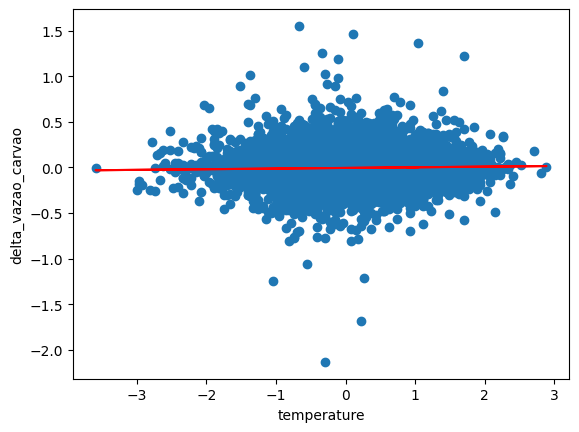

[[-0.01028361]]


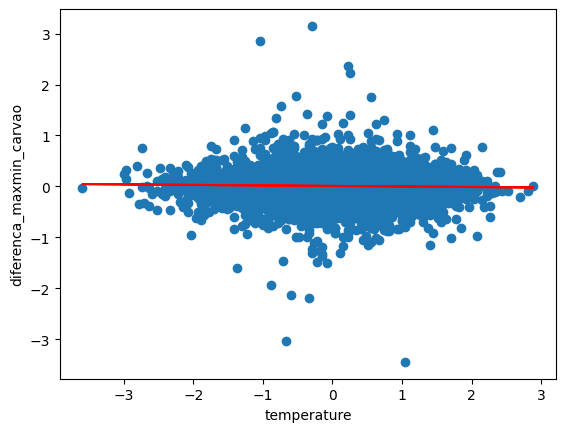

In [56]:
plot_reg_linear(gb,'temperature','delta_vazao_carvao')
plot_reg_linear(gb,'temperature','diferenca_maxmin_carvao')

In [57]:
gb

,delta_time_previous30min,run_max_temp_t1,delta_time_max_run_t1,run_max_temp_tsame1,delta_time_max_tsame1,processo_volume-de-sopro,indices_operacionais_taxa-de-o2,processo_umidade-do-ar-de-sopro,processo_temperatura-do-ar-de-sopro,processo_vazao-de-carvao-na-linha-principal,...,lag_15_carga_coque-rate,lag_15_carga_minerio-rate,temperature,run_id,date,date_prev_run_max_temp,id_delta_vazao_carvao,delta_vazao_carvao,id_diferenca_maxmin_carvao,diferenca_maxmin_carvao
0,-1.110906,0.592593,-0.822649,0.925926,1.402857,-0.321422,0.325029,0.015190,0.850186,0.437104,...,-4.923262,-5.097123,0.888889,14045.0,2017-01-02 02:00:00,1970-01-01 00:00:00,0,0.000000,0,0.000000
3,-1.132028,0.888889,-0.335365,0.888889,-0.335365,-0.193533,0.271147,-0.362025,0.925788,-0.038009,...,-4.923262,-5.097123,0.925926,14047.0,2017-01-02 06:00:00,2017-01-02 02:00:00,1,0.198597,1,-0.475113
5,-1.135045,0.925926,-0.649732,0.592593,0.594187,-0.344727,0.313441,-0.402532,0.051484,0.038009,...,-4.923262,-5.097123,0.777778,14048.0,2017-01-02 08:30:00,2017-01-02 06:00:00,2,0.038612,2,0.076018
8,-1.094587,0.777778,-0.799495,0.925926,-0.165897,-0.316761,0.322711,-0.503797,-0.034323,0.190950,...,-4.923262,-5.097123,1.111111,14049.0,2017-01-02 10:30:00,2017-01-02 08:30:00,3,-0.065762,3,0.152941
13,-1.153581,1.111111,-0.594864,0.777778,-0.193423,-0.771121,-0.284473,0.068354,0.429499,-0.000905,...,-4.923262,-5.097123,0.111111,14050.0,2017-01-02 13:30:00,2017-01-02 10:30:00,4,0.145626,4,-0.191855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38483,-1.151364,1.777778,-0.800665,1.814815,0.212636,0.214362,0.272885,1.931646,-1.781076,-0.489593,...,1.267675,0.594587,2.407408,23470.0,2019-12-31 12:00:00,2019-12-31 08:30:00,8934,-0.099321,8934,0.284163
38488,-1.110413,2.407407,-0.835027,1.777778,-0.094649,0.199699,0.495944,1.951899,-2.010668,-0.447059,...,1.309009,0.422376,1.962963,23471.0,2019-12-31 15:00:00,2019-12-31 12:00:00,8935,-0.014253,8935,0.042534
38494,-1.193546,1.962963,-0.571094,2.407407,-0.142250,0.228151,0.498841,2.098734,-2.207328,-0.475113,...,0.950531,0.648183,2.333333,23472.0,2019-12-31 18:30:00,2019-12-31 15:00:00,8936,-0.013348,8936,-0.028054
38501,-1.189975,2.333333,-0.643143,1.962963,-0.013301,0.225529,0.508691,1.734177,-1.326067,-0.103167,...,0.982544,0.646013,1.111111,23473.0,2019-12-31 21:00:00,2019-12-31 18:30:00,8937,-0.175867,8937,0.371946
